# CNN Cancer Detection Kaggle Project
## Brief description of the problem and data 

The problem we have been given is to use a Convolutional Neural Network to detect cancer in a set of medical images. We are given a large number of images, along with labels whether they contain cancer cells or not. We will train a CNN to do a binary classification of cancer vs. not cancer. If a deep learning system could detect cancer better than a human can, it could be a benefit to medicine.

In [16]:
import pandas as pd
import numpy as np
from numpy.random import seed
seed(2718)
import tensorflow as tf
from tensorflow import keras
import cv2
import matplotlib.pyplot as plt
import os

In [17]:
DATA_DIR = '../input/histopathologic-cancer-detection'
eda_samples = os.listdir(DATA_DIR + '/train')[:30]
eda_samples[:10]

['d43c081bafa286f9c1f7e921883f26ceafebc912.tif',
 '092d0eedebce504847715ee046b6ad74b57599b4.tif',
 'b0d2582c6218a8764323fc940b41312282b99bf4.tif',
 '187c99df762f13f99818e5593d4bab4c6577e7e3.tif',
 '7c5270c83837de5a5cbb2dca511559dc39d19d53.tif',
 '5a32933e093185f5fc91d30fc83ad571c6818d25.tif',
 '42e77d193e73811e0bb65a0cbd9b01c5c27900fa.tif',
 '27bb898f54a0b9345f6c4a9083299e4465860861.tif',
 '89cd55e4300440612347c38f306da688a166fd40.tif',
 'cd600f77aa2af7c93dc6cd836e44edada3d8c403.tif']

## Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data

Since these are images, the first question is what they actually look like. How big are they? Are they uniform in brightness, orientation, etc.?

(96, 96, 3)


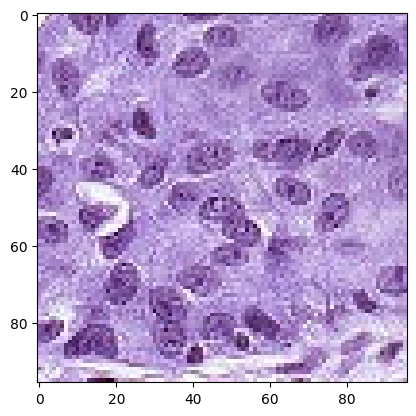

In [18]:
chosenfile = DATA_DIR + "/train/" + eda_samples[0]

img = cv2.imread(chosenfile)
plt.imshow(img)

print(img.shape)

So, the images are 96px by 96px, and using 3 color channels. It's not clear that we need all 3, or if a greyscale image would be equally useful. so I am going to look at each channel separately:

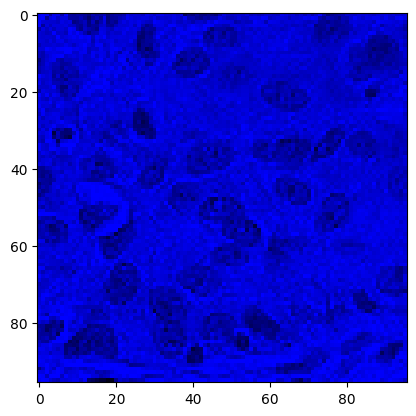

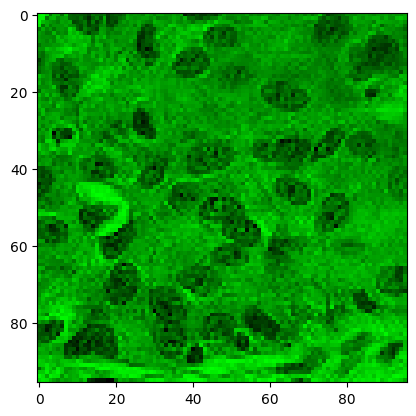

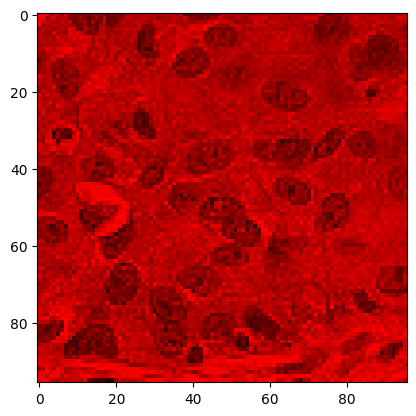

In [19]:
import copy

img2 = copy.copy(img)
img2[:,:,0] = 0
img2[:,:,1] = 0
plt.imshow(img2)
plt.show()

img2 = copy.copy(img)
img2[:,:,0] = 0
img2[:,:,2] = 0
plt.imshow(img2)
plt.show()

img2 = copy.copy(img)
img2[:,:,1] = 0
img2[:,:,2] = 0
plt.imshow(img2)

plt.show()

they look pretty much identical to me. So switching to greyscale may be a way to reduce dimensionality without losing too much information.

Now, let's look at the distribution of training labels.

In [20]:
training_df = pd.read_csv(DATA_DIR + "/train_labels.csv")
training_df.sample(10)

,id,label
75706,550265437358795e08b53e2b37df46c0f9211e89,0
4820,c45073be503e32d5668d993842254559c87526f5,1
154454,33fe4fa885a73826e020d945db2420465becb3e1,0
83490,07b2ee314dbf3dc19d09d84e53c70bb6b0193bd4,0
210788,3a0a8924dac3e9387b835d03b8fc9635d4ea2a91,0
186666,cd4cb5330df7d58e52af8d92402019278c0199c1,1
138530,8a84a79729af0e2c5936eb4b03a1e9484b823b84,1
118835,3f386b74a5896d2837b0bdfa5d76f05120cc0cf6,1
42455,2e481a9267e35092ce960f361726097d6e42acf2,0
54353,33e48b3678e28aacc4e324ff8c6b93f69fa4008b,1


In [21]:
train_false = training_df[training_df.label == 0]
train_true = training_df[training_df.label == 1]

training_df.label.value_counts()

label
0    130908
1     89117
Name: count, dtype: int64

That's a lot of data. I don't think it's going to be practical to train on the whole set.

There is also a slight class imbalance. I will make sure the training set contains an equal number of each.

In [22]:
train_false_sample = train_false.sample(1100)
train_true_sample = train_true.sample(1100)

train_sample = pd.concat([train_false_sample, train_true_sample], axis=0)
train_sample.label.value_counts()

label
0    1100
1    1100
Name: count, dtype: int64

it's important to shuffle the training data, so we can take a slice of it and expect to get a balanced number of 0 and 1 labels.

In [23]:
train_sample = train_sample.sample(frac=1).reset_index(drop=True)
print(train_sample.head())

                                         id  label
0  80fb07a4ab93d107c255f2d18ac975f6f3eef061      1
1  bfa50a94cd0a03f1423b933a6091bd298d1e12bc      0
2  f5d93be115b8a1ac40da4008b57f8eed57d8f54b      1
3  2f50aebe0fe55f1893cac5ed95c86f732d0661c9      1
4  72e7006ed5bdc2c60ce99aafca705b3236c931bc      0


I think we want to normalize the color channels to be between 0 and 1. they are currently between 0 and 255.

In [24]:
print(img[:,:,0].min())
print(img[:,:,1].min())
print(img[:,:,2].min())

print(img[:,:,0].max())
print(img[:,:,1].max())
print(img[:,:,2].max())

31
0
23
255
255
255


the ImageDataGenerator contains a rescale option which will do the normalization.

In [26]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

data_gen = ImageDataGenerator(rescale=1/255.0)

Last bit of EDA I want to look at is the brightness of images. are some much darker/lighter than others? I will look at a sample of 30 images.

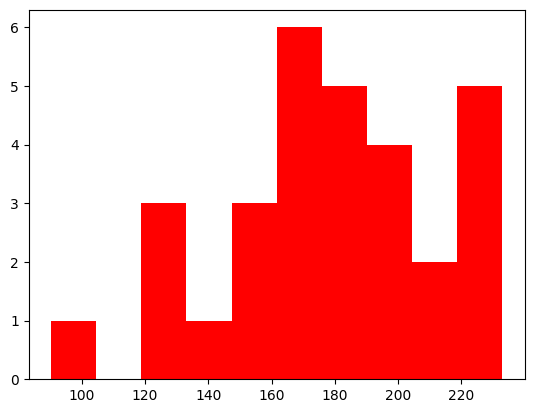

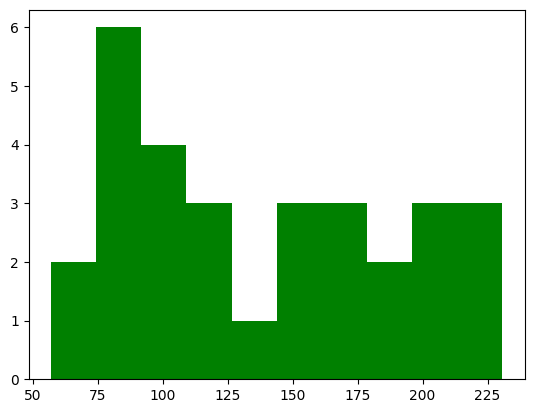

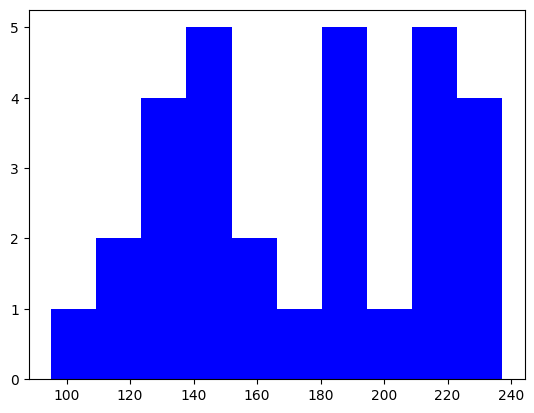

In [27]:
chan0_means = []
chan1_means = []
chan2_means = []

for sample in eda_samples:
    f = DATA_DIR + "/train/" + sample
    _img = cv2.imread(f)
    chan0_means.append(_img[:,:,0].mean())
    chan1_means.append(_img[:,:,1].mean())
    chan2_means.append(_img[:,:,2].mean())
    
foo = plt.hist(chan0_means, color='red') 
plt.show()
foo = plt.hist(chan1_means, color='green')
plt.show()
foo = plt.hist(chan2_means, color='blue')
plt.show()

In [28]:
df_chan = pd.DataFrame({"red": chan0_means, "green": chan1_means, "blue": chan2_means})
df_chan.describe()

,red,green,blue
count,30.000000,30.000000,30.000000
mean,178.635406,137.980360,174.223054
std,34.645388,52.843328,41.316643
min,90.295356,57.130100,95.156576
25%,160.466634,92.716309,139.731472
50%,176.384440,134.162001,180.881944
75%,201.224989,182.507080,211.256456
max,232.847548,230.588867,237.181207


Those seem fairly reasonable ranges. Brightness doesn't look normally distributed, but I don't think it needs to be. So I won't worry about normalizing brightness.

## Model Architecture 

I think it is always a good idea to have a very simple model to serve as a baseline. a 100x more complex model might not be any better.

I am basing this on the tutorial here: https://keras.io/examples/vision/mnist_convnet/

In [29]:
input_shape = (96,96,3) # will use all 3 channels for now.

from tensorflow.keras import layers

trivial_model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(2, activation="softmax"),
    ]
)

trivial_model.summary()

trivial_model.compile(loss="categorical_crossentropy", 
                      optimizer="adam", metrics=["AUC"])

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 94, 94, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 47, 47, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2)              │        61,954 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 81,346 (317.76 KB)

 Trainable params: 81,346 (317.76 KB)

 Non-trainable params: 0 (0.00 B)

In [30]:
VALIDATION_SIZE = 200
batch_size = 100
epochs = 10

train_sample['filename'] = train_sample['id'] + ".tif"
train_sample['s_label'] = train_sample['label'].apply(str)

train_generator = data_gen.flow_from_dataframe(
    train_sample[:-VALIDATION_SIZE],
    directory= DATA_DIR + "/train/",
    x_col="filename",
    y_col="s_label",
    target_size=(96,96),
    batch_size = batch_size
)
val_generator = data_gen.flow_from_dataframe(
    train_sample[-VALIDATION_SIZE:],
    directory= DATA_DIR + "/train/",
    x_col="filename",
    y_col="s_label",
    target_size=(96,96),
    batch_size = batch_size
)

Found 2000 validated image filenames belonging to 2 classes.
Found 200 validated image filenames belonging to 2 classes.


In [31]:
trivial_hist = trivial_model.fit(train_generator, batch_size=batch_size, 
                                 epochs=10,validation_data=val_generator)

Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 1/20 ━━━━━━━━━━━━━━━━━━━━ 3:09 10s/step - AUC: 0.5093 - loss: 0.7308

W0000 00:00:1721956567.395297     199 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


20/20 ━━━━━━━━━━━━━━━━━━━━ 17s 393ms/step - AUC: 0.5145 - loss: 0.8988 - val_AUC: 0.6416 - val_loss: 0.6667
Epoch 2/10


W0000 00:00:1721956574.862046     199 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - AUC: 0.5926 - loss: 0.6701 - val_AUC: 0.7391 - val_loss: 0.6164
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - AUC: 0.6982 - loss: 0.6309 - val_AUC: 0.8603 - val_loss: 0.5284
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - AUC: 0.8098 - loss: 0.5457 - val_AUC: 0.8040 - val_loss: 0.5439
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step - AUC: 0.7794 - loss: 0.5698 - val_AUC: 0.8184 - val_loss: 0.5207
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - AUC: 0.8476 - loss: 0.4862 - val_AUC: 0.8554 - val_loss: 0.4743
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - AUC: 0.8501 - loss: 0.4813 - val_AUC: 0.8556 - val_loss: 0.4714
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - AUC: 0.8596 - loss: 0.4694 - val_AUC: 0.8418 - val_loss: 0.4862
Epoch 9/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - AUC: 0.8781 - loss: 0.4456 - val_AUC: 0.8507 - val_loss: 0.4816
Epoch 10/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - AUC: 0.8534 

ok, let's look at AUC versus validation AUC to see if we're overfitting

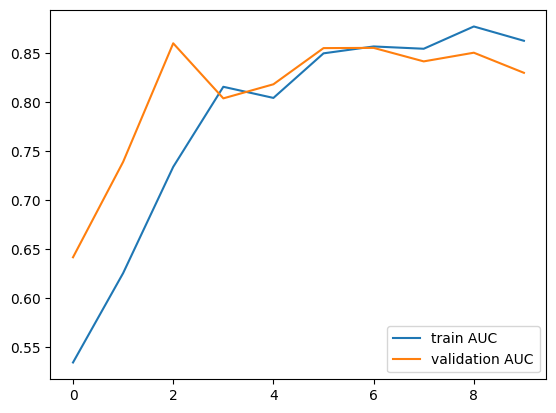

In [32]:

plt.plot(trivial_hist.history['AUC'], label='train AUC')
plt.plot(trivial_hist.history['val_AUC'], label='validation AUC')
plt.legend()
plt.show()

it looks like training and validation diverge at around an AUC of .85. That's not bad for a model that only took a couple of minutes to train, but the competition winners are getting close to 1.000.

## A More Complex Model

For my next try, I will build a very similar model, but with a more complex structure. I added 128 and 256 convolution layers. That leads to 4x as many parameters to be estimated. Will that lead to 4x accuracy? we shall see!

In [33]:
input_shape = (96,96,3) 

batch_size=100
epochs=10

model2 = keras.Sequential(
    [
        keras.Input(shape=input_shape),

        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),        

        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),        
        
        layers.Conv2D(128, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)), 
        
        layers.Conv2D(256, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(2, activation="softmax")
        
    ]
)
model2.summary()

model2.compile(loss="binary_crossentropy", 
                        optimizer="adam", 
                        metrics=["AUC"])
model2_hist = model2.fit(train_generator, 
                                     batch_size=batch_size, 
                                     epochs=epochs,
                                     validation_data=val_generator)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 94, 94, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 47, 47, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 20, 20, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │         8,194 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 396,610 (1.51 MB)

 Trainable params: 396,610 (1.51 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 158ms/step - AUC: 0.5334 - loss: 0.6937 - val_AUC: 0.7326 - val_loss: 0.6341
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - AUC: 0.6988 - loss: 0.6338 - val_AUC: 0.8459 - val_loss: 0.4930
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 122ms/step - AUC: 0.8175 - loss: 0.5260 - val_AUC: 0.8309 - val_loss: 0.5123
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 122ms/step - AUC: 0.8162 - loss: 0.5271 - val_AUC: 0.8409 - val_loss: 0.4958
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - AUC: 0.8251 - loss: 0.5176 - val_AUC: 0.8432 - val_loss: 0.4913
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - AUC: 0.8402 - loss: 0.4973 - val_AUC: 0.8504 - val_loss: 0.4809
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - AUC: 0.8273 - loss: 0.5148 - val_AUC: 0.8581 - val_loss: 0.4721
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - AUC: 0.8424 - loss: 0.4929 - val_AUC: 0.8452 - val_loss: 0.4940
Epoch 9/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - A

Oh no! It's not an obvious improvement over the trivial model. On a positive note it doesn't look like we're overtraining yet, since train and validation AUC are similar. So we might be able to increase the number of epochs. But I wouldn't expect it to get much better. it's not getting close to 1.0 on the training data.

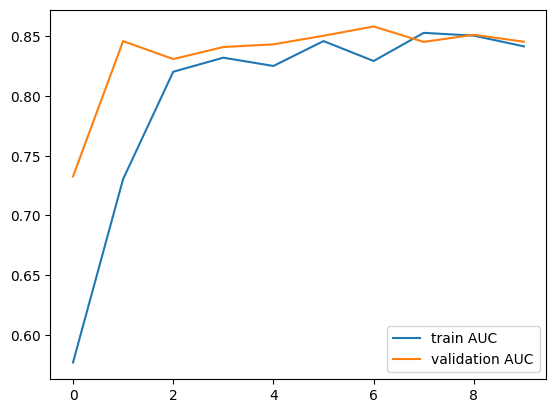

In [34]:
plt.plot(model2_hist.history['AUC'], label='train AUC')
plt.plot(model2_hist.history['val_AUC'], label='validation AUC')
plt.legend()
plt.show()

## Batch Normalization

batch normalization is a technique we learned about in class. we are currently using dropout, which serves as a form of normalization, but perhaps normalization at each layer will improve the model. Other than that, I will keep the model the same.

I found the validation AUC improves much more slowly with this model than the previous 2, so I am running it for more epochs.

In [35]:
input_shape = (96,96,3) 

batch_size=100
epochs=40

model3 = keras.Sequential(
    [
        keras.Input(shape=input_shape),

        layers.Conv2D(32, kernel_size=(3, 3)),
        layers.BatchNormalization(),
        layers.ReLU(),
        layers.MaxPooling2D(pool_size=(2, 2)),        

        layers.Conv2D(64, kernel_size=(3, 3)),
        layers.BatchNormalization(),
        layers.ReLU(),
        layers.MaxPooling2D(pool_size=(2, 2)),    
        
        layers.Conv2D(128, kernel_size=(3, 3)),
        layers.BatchNormalization(),
        layers.ReLU(),
        layers.MaxPooling2D(pool_size=(2, 2)),    
        
        layers.Conv2D(256, kernel_size=(3, 3)),
        layers.BatchNormalization(),
        layers.ReLU(),
        layers.MaxPooling2D(pool_size=(2, 2)),    
        
        layers.Flatten(),
        layers.Dense(2, activation="softmax")
        
    ]
)
model3.summary()

model3.compile(loss="binary_crossentropy", 
                        optimizer="adam", 
                        metrics=["AUC"])
model3_hist = model3.fit(train_generator, 
                                     batch_size=batch_size, 
                                     epochs=epochs,
                                     validation_data=val_generator)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 94, 94, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 94, 94, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 94, 94, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 47, 47, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 45, 45, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 45, 45, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 20, 20, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 20, 20, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_3 (ReLU)                  │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │         8,194 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 398,530 (1.52 MB)

 Trainable params: 397,570 (1.52 MB)

 Non-trainable params: 960 (3.75 KB)

Epoch 1/40
20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 173ms/step - AUC: 0.7187 - loss: 0.7969 - val_AUC: 0.4424 - val_loss: 0.8583
Epoch 2/40
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - AUC: 0.8767 - loss: 0.4483 - val_AUC: 0.4771 - val_loss: 0.8412
Epoch 3/40
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step - AUC: 0.9030 - loss: 0.4025 - val_AUC: 0.5352 - val_loss: 0.7534
Epoch 4/40
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 116ms/step - AUC: 0.9521 - loss: 0.3002 - val_AUC: 0.5689 - val_loss: 0.8004
Epoch 5/40
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - AUC: 0.9674 - loss: 0.2493 - val_AUC: 0.5650 - val_loss: 1.3526
Epoch 6/40
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - AUC: 0.9827 - loss: 0.1839 - val_AUC: 0.5962 - val_loss: 0.8423
Epoch 7/40
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - AUC: 0.9945 - loss: 0.1141 - val_AUC: 0.5827 - val_loss: 0.9767
Epoch 8/40
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - AUC: 0.9987 - loss: 0.0676 - val_AUC: 0.5784 - val_loss: 1.4095
Epoch 9/40
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - A

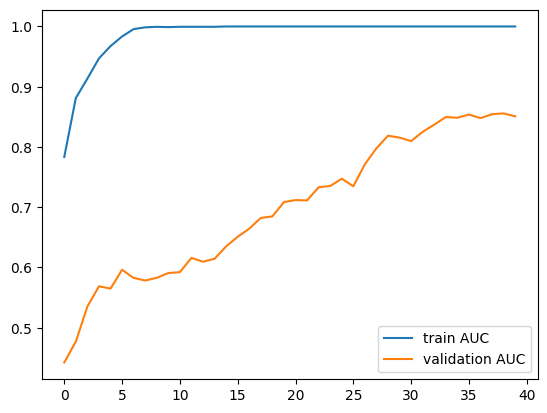

In [36]:
plt.plot(model3_hist.history['AUC'], label='train AUC')
plt.plot(model3_hist.history['val_AUC'], label='validation AUC')
plt.legend()
plt.show()

It's possible that more epochs could lead to a higher validation AUC, or a different learning algorithm would do a better job. But this model seems unlikely to break an AUC score of .9

So, I will try a much more complex model next. In class, a \[conv, conv, pool] structure was recommended. I am increasing the number of epochs because there are so many more parameters to fit.

In [37]:
input_shape = (96,96,3) 

batch_size=100
epochs=15

model4 = keras.Sequential(
    [
        keras.Input(shape=input_shape),

        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),        

        layers.Conv2D(128, kernel_size=(3, 3), activation="relu"),
        layers.Conv2D(128, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),        
        
        layers.Conv2D(256, kernel_size=(3, 3), activation="relu"),
        layers.Conv2D(256, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)), 
        
        layers.Conv2D(512, kernel_size=(3, 3), activation="relu"),
        layers.Conv2D(512, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(2, activation="softmax")
        
    ]
)
model4.summary()

model4.compile(loss="binary_crossentropy", 
                        optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001), 
                        metrics=["AUC"])
model4_hist = model4.fit(train_generator, 
                                     batch_size=batch_size, 
                                     epochs=epochs,
                                     validation_data=val_generator)

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)              │ (None, 94, 94, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 92, 92, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 46, 46, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 44, 44, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 42, 42, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 21, 21, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 19, 19, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 17, 17, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 6, 6, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │         4,098 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,689,474 (17.89 MB)

 Trainable params: 4,689,474 (17.89 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
 1/20 ━━━━━━━━━━━━━━━━━━━━ 7:55 25s/step - AUC: 0.4979 - loss: 0.6934

W0000 00:00:1721956946.664077     199 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


20/20 ━━━━━━━━━━━━━━━━━━━━ 29s 214ms/step - AUC: 0.4792 - loss: 0.6987 - val_AUC: 0.5250 - val_loss: 0.6923
Epoch 2/15


W0000 00:00:1721956950.835284     202 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 160ms/step - AUC: 0.5719 - loss: 0.6903 - val_AUC: 0.6364 - val_loss: 0.6885
Epoch 3/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 160ms/step - AUC: 0.6024 - loss: 0.6805 - val_AUC: 0.6884 - val_loss: 0.6696
Epoch 4/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 155ms/step - AUC: 0.6476 - loss: 0.6670 - val_AUC: 0.6883 - val_loss: 0.6375
Epoch 5/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 167ms/step - AUC: 0.7421 - loss: 0.6045 - val_AUC: 0.7968 - val_loss: 0.5506
Epoch 6/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 157ms/step - AUC: 0.7876 - loss: 0.5634 - val_AUC: 0.8253 - val_loss: 0.5333
Epoch 7/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 158ms/step - AUC: 0.8119 - loss: 0.5401 - val_AUC: 0.8051 - val_loss: 0.5562
Epoch 8/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 164ms/step - AUC: 0.8420 - loss: 0.4954 - val_AUC: 0.8765 - val_loss: 0.4573
Epoch 9/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 160ms/step - AUC: 0.8458 - loss: 0.4912 - val_AUC: 0.8712 - val_loss: 0.4555
Epoch 10/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 158ms/step - AUC: 0.8416 

I retrained this model many times.

I was able to get a validation AUC of .9483 with this model once, which is quite good. However, several runs (like the one above) got scores closer to .86, like the other models, so there's an element of luck.

## Increasing training data size

Perhaps we will get a more robust model with more data? I will increase the amount of training data and try the previous model again.

At first, I had a lot of runs that stalled out on the bigger data due to vanishing gradient (aka the "dying relu" problem). so I switched the activation functions to leaky_relu but otherwise kept the model the same.

In [38]:
VALIDATION_SIZE = 200
batch_size=100

train_false_sample = train_false.sample(10000)
train_true_sample = train_true.sample(10000)

train_sample = pd.concat([train_false_sample, train_true_sample], axis=0)

datagen = ImageDataGenerator(rescale=1./255.)

train_sample['filename'] = train_sample['id'] + ".tif"
train_sample['s_label'] = train_sample['label'].apply(str)
train_sample = train_sample.sample(frac=1).reset_index(drop=True)

In [39]:
train_generator2 = data_gen.flow_from_dataframe(
    train_sample[:-VALIDATION_SIZE],
    directory= DATA_DIR + "/train/",
    x_col="filename",
    y_col="s_label",
    target_size=(96,96),
    batch_size = batch_size
)
val_generator2 = data_gen.flow_from_dataframe(
    train_sample[-VALIDATION_SIZE:],
    directory= DATA_DIR + "/train/",
    x_col="filename",
    y_col="s_label",
    target_size=(96,96),
    batch_size = batch_size
)

Found 19800 validated image filenames belonging to 2 classes.
Found 200 validated image filenames belonging to 2 classes.


In [40]:
batch_size=100
epochs=15

model5 = keras.Sequential(
    [
        keras.Input(shape=(96,96,3)),
    
        layers.Conv2D(64, kernel_size=(3, 3), activation="leaky_relu"),
        layers.Conv2D(64, kernel_size=(3, 3), activation="leaky_relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),        

        layers.Conv2D(128, kernel_size=(3, 3), activation="leaky_relu"),
        layers.Conv2D(128, kernel_size=(3, 3), activation="leaky_relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),        
        
        layers.Conv2D(256, kernel_size=(3, 3), activation="leaky_relu"),
        layers.Conv2D(256, kernel_size=(3, 3), activation="leaky_relu"),
        layers.MaxPooling2D(pool_size=(2, 2)), 
        
        layers.Conv2D(512, kernel_size=(3, 3), activation="leaky_relu"),
        layers.Conv2D(512, kernel_size=(3, 3), activation="leaky_relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(2, activation="softmax")      
    ]
)
model5.summary()

model5.compile(loss="binary_crossentropy", 
                        optimizer=tf.keras.optimizers.Adam(),
               #optimizer=tf.keras.optimizers.RMSprop(),
                        metrics=["AUC"])
model5_hist = model5.fit(train_generator2, 
                                     batch_size=batch_size, 
                                     epochs=epochs,
                                     validation_data=val_generator2)

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_18 (Conv2D)              │ (None, 94, 94, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 92, 92, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 46, 46, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 44, 44, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 42, 42, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 21, 21, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 19, 19, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 17, 17, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 6, 6, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 2)              │         4,098 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,689,474 (17.89 MB)

 Trainable params: 4,689,474 (17.89 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
W0000 00:00:1721957204.316532     199 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


198/198 ━━━━━━━━━━━━━━━━━━━━ 119s 496ms/step - AUC: 0.5824 - loss: 0.6925 - val_AUC: 0.8290 - val_loss: 0.5127
Epoch 2/15


W0000 00:00:1721957301.991126     199 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


198/198 ━━━━━━━━━━━━━━━━━━━━ 34s 165ms/step - AUC: 0.8236 - loss: 0.5210 - val_AUC: 0.8466 - val_loss: 0.4941
Epoch 3/15
198/198 ━━━━━━━━━━━━━━━━━━━━ 34s 164ms/step - AUC: 0.8562 - loss: 0.4759 - val_AUC: 0.8717 - val_loss: 0.4579
Epoch 4/15
198/198 ━━━━━━━━━━━━━━━━━━━━ 34s 164ms/step - AUC: 0.8648 - loss: 0.4626 - val_AUC: 0.8616 - val_loss: 0.4760
Epoch 5/15
198/198 ━━━━━━━━━━━━━━━━━━━━ 34s 164ms/step - AUC: 0.8815 - loss: 0.4342 - val_AUC: 0.9077 - val_loss: 0.3891
Epoch 6/15
198/198 ━━━━━━━━━━━━━━━━━━━━ 41s 164ms/step - AUC: 0.8996 - loss: 0.4000 - val_AUC: 0.9088 - val_loss: 0.3810
Epoch 7/15
198/198 ━━━━━━━━━━━━━━━━━━━━ 34s 165ms/step - AUC: 0.9115 - loss: 0.3775 - val_AUC: 0.9042 - val_loss: 0.3873
Epoch 8/15
198/198 ━━━━━━━━━━━━━━━━━━━━ 34s 164ms/step - AUC: 0.9252 - loss: 0.3439 - val_AUC: 0.9289 - val_loss: 0.3428
Epoch 9/15
198/198 ━━━━━━━━━━━━━━━━━━━━ 34s 164ms/step - AUC: 0.9312 - loss: 0.3295 - val_AUC: 0.9288 - val_loss: 0.3226
Epoch 10/15
198/198 ━━━━━━━━━━━━━━━━━━━━ 34

I ran the above model many times and there's a huge variance in output. some models ran away to infinity, ending with an AUC worse than guessing. Unfortunately, I didn't collect statistics on those runs, but the best validation AUC I was able to get was .9430.

## Hyperparameter Tuning (Learning Rate)

Because of the variance in output, it's possible we'd get better results with a better learning rate. I will use the keras tuner library to find it: https://keras.io/guides/keras_tuner/getting_started/

In [41]:
def build_model(hp):
    ret_model = keras.Sequential(
        [
            keras.Input(shape=(96,96,3)),

            layers.Conv2D(64, kernel_size=(3, 3), activation="leaky_relu"),
            layers.Conv2D(64, kernel_size=(3, 3), activation="leaky_relu"),
            layers.MaxPooling2D(pool_size=(2, 2)),        

            layers.Conv2D(128, kernel_size=(3, 3), activation="leaky_relu"),
            layers.Conv2D(128, kernel_size=(3, 3), activation="leaky_relu"),
            layers.MaxPooling2D(pool_size=(2, 2)),        

            layers.Conv2D(256, kernel_size=(3, 3), activation="leaky_relu"),
            layers.Conv2D(256, kernel_size=(3, 3), activation="leaky_relu"),
            layers.MaxPooling2D(pool_size=(2, 2)), 

            layers.Conv2D(512, kernel_size=(3, 3), activation="leaky_relu"),
            layers.Conv2D(512, kernel_size=(3, 3), activation="leaky_relu"),
            layers.MaxPooling2D(pool_size=(2, 2)),

            layers.Flatten(),
            layers.Dropout(0.5),
            layers.Dense(2, activation="softmax")      
        ]
    )
    # this is where the magic happens...
    lr = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
    
    ret_model.compile(loss="binary_crossentropy", 
                    optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                    metrics=["AUC"])
    return ret_model
    

In [42]:
import keras_tuner

tuner = keras_tuner.RandomSearch(
    hypermodel=build_model,
    objective="val_AUC",
    max_trials=3,
    executions_per_trial=2,
    overwrite=True,
    directory="/kaggle/working",
    project_name="cancer",
)
tuner.search_space_summary()

Search space summary
Default search space size: 1
lr (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


I will test a range of learning rates with 5 epochs each time. that should be enough to figure out if a learning rate is too big or too small.

In [43]:
train_generator.reset()
val_generator.reset()

x_train, y_train = next(train_generator)
x_val, y_val = next(val_generator)
tuner.search(x_train, y_train, epochs=5, validation_data=(x_val, y_val))

Trial 3 Complete [00h 00m 23s]
val_AUC: 0.605650007724762

Best val_AUC So Far: 0.628350019454956
Total elapsed time: 00h 01m 24s


In [44]:
best_hp =tuner.get_best_hyperparameters()[0]

In [45]:
best_hp.get("lr")

0.0005579877919933368

the optimal learning rate it found (above) is pretty close to the default Adam learning rate of .001, which is what we have been using for previous models:
https://keras.io/api/optimizers/adam/

So I don't think there are any big benefits there.

## Tuning - Robustness of Training Data

Whenever we're dealing with image data, we have to worry about recognizing images that have been rotated or shifted in some way. A picture of a dog turned 90 degrees should still register as a dog. This has long been a problem in computer vision, and one that convolutional networks can help solve.  Keras has some built in layers to alter the image. This should lead to longer training cycles but more robust models (and hopefully, higher AUC on the test images).

This model is identical to the previous, with the addition of a RandomFlip() layer.

In [46]:
epochs = 20
from keras import layers

model6 = keras.Sequential(
    [
        keras.Input(shape=(96,96,3)),
        
        layers.RandomFlip(seed=2718),
        
        layers.Conv2D(64, kernel_size=(3, 3), activation="leaky_relu"),
        layers.Conv2D(64, kernel_size=(3, 3), activation="leaky_relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),        

        layers.Conv2D(128, kernel_size=(3, 3), activation="leaky_relu"),
        layers.Conv2D(128, kernel_size=(3, 3), activation="leaky_relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),        
        
        layers.Conv2D(256, kernel_size=(3, 3), activation="leaky_relu"),
        layers.Conv2D(256, kernel_size=(3, 3), activation="leaky_relu"),
        layers.MaxPooling2D(pool_size=(2, 2)), 
        
        layers.Conv2D(512, kernel_size=(3, 3), activation="leaky_relu"),
        layers.Conv2D(512, kernel_size=(3, 3), activation="leaky_relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(2, activation="softmax")      
    ]
)
model6.summary()

model6.compile(loss="binary_crossentropy", 
                        optimizer=tf.keras.optimizers.Adam(),
                        metrics=["AUC"])
model6_hist = model6.fit(train_generator2, 
                                     batch_size=batch_size, 
                                     epochs=epochs,
                                     validation_data=val_generator2)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_flip (RandomFlip)        │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 94, 94, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 92, 92, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 46, 46, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 44, 44, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 42, 42, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 21, 21, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 19, 19, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 17, 17, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 6, 6, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │         4,098 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,689,474 (17.89 MB)

 Trainable params: 4,689,474 (17.89 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20


W0000 00:00:1721958010.537277     202 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


198/198 ━━━━━━━━━━━━━━━━━━━━ 42s 168ms/step - AUC: 0.5409 - loss: 0.7023 - val_AUC: 0.7017 - val_loss: 0.6623
Epoch 2/20


W0000 00:00:1721958043.776880     199 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


198/198 ━━━━━━━━━━━━━━━━━━━━ 34s 167ms/step - AUC: 0.7569 - loss: 0.5919 - val_AUC: 0.8398 - val_loss: 0.4992
Epoch 3/20
198/198 ━━━━━━━━━━━━━━━━━━━━ 34s 164ms/step - AUC: 0.8388 - loss: 0.5006 - val_AUC: 0.8706 - val_loss: 0.4541
Epoch 4/20
198/198 ━━━━━━━━━━━━━━━━━━━━ 34s 164ms/step - AUC: 0.8499 - loss: 0.4846 - val_AUC: 0.8507 - val_loss: 0.4954
Epoch 5/20
198/198 ━━━━━━━━━━━━━━━━━━━━ 34s 165ms/step - AUC: 0.8672 - loss: 0.4583 - val_AUC: 0.8912 - val_loss: 0.4427
Epoch 6/20
198/198 ━━━━━━━━━━━━━━━━━━━━ 34s 164ms/step - AUC: 0.8712 - loss: 0.4520 - val_AUC: 0.8777 - val_loss: 0.4411
Epoch 7/20
198/198 ━━━━━━━━━━━━━━━━━━━━ 34s 164ms/step - AUC: 0.8874 - loss: 0.4248 - val_AUC: 0.8996 - val_loss: 0.3933
Epoch 8/20
198/198 ━━━━━━━━━━━━━━━━━━━━ 34s 164ms/step - AUC: 0.9041 - loss: 0.3925 - val_AUC: 0.9146 - val_loss: 0.3789
Epoch 9/20
198/198 ━━━━━━━━━━━━━━━━━━━━ 34s 164ms/step - AUC: 0.9051 - loss: 0.3888 - val_AUC: 0.9033 - val_loss: 0.4050
Epoch 10/20
198/198 ━━━━━━━━━━━━━━━━━━━━ 41

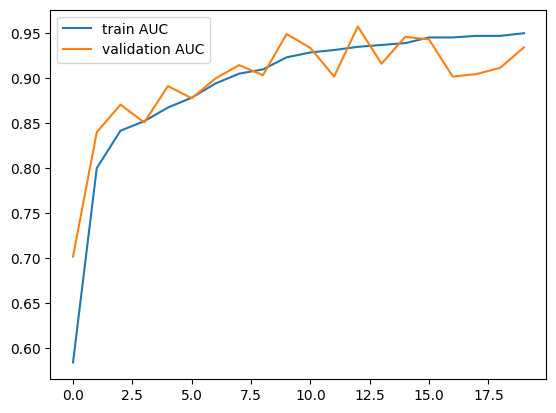

In [47]:
plt.plot(model6_hist.history['AUC'], label='train AUC')
plt.plot(model6_hist.history['val_AUC'], label='validation AUC')
plt.legend()
plt.show()

In [48]:
model6.save("bestyet.keras")

## Conclusions

Let's summarize the model and their performances. The results were very volatile, so we can't draw too many conclusions from relative values. Each time I run the models, I slightly get different results. However, only the most complex model ever broke .9.

Model         | Best Validation AUC | Approx Number of Parameters
--------------| --------------------|----------------
trivial | .8556 | 81,000
Model 2 | .8581 | 397,000
Batch Normalization | .8557 | 397,000
Most Complex Model | .8765 | 4,700,000
Most Complex Plus More Data | .9430 | 4,700,000
Most Complex Plus Robust Data | .9460 | 4,700,000


For me, it's surprising I had to make the model vastly more complex (in terms of parameters to estimate) in order to see a substantial improvement. However, I tested a lot of complex models that didn't work at all (not included here), so it's not model complexity alone. There really is some lore about which layers to use when, what size to make the convolutions, and so on. My models ended up being similar to the classical CNN architecture because nothing else I tried worked well enough to be an improvement on the trivial model.

Above a certain level of complexity, I had to switch to using leaky ReLU as the activation to avoid stalling out. That's an important lesson for bigger models.

I found that the optimal learning rate was very close to the default learning rate for the Adam optimizer.

Making the data more robust by introducing the Flip layer didn't seem to hurt the effectiveness of the model but did make training longer. 
## Next Steps

I kept the training data small because I had limited compute resources. It would be interesting to see how the model would do with more training data.

In general, this problem seems like a perfect job for transfer learning. Transfer learning is where you take a model that has been trained on a huge number of general-purpose images, then add additional layers at the end that would get trained to do binary classification of these specific cancer images. Every computer vision system trained from scratch has to re-learn basics like shapes and edge detection. Transfer learning would give us a good jumpstart.

## Submitting to kaggle...

I was getting terrible kaggle scores until I realized that the inputs were being shuffled by the ImageDataGenerator(), making my predictions essentially random. It's imperative to have 'shuffle=False' set to avoid this!

having fixed that, my final submission got a .8018 private score and a .8411 public score.

In [5]:
test_data= pd.read_csv(DATA_DIR + "/sample_submission.csv")
test_data['filename'] = test_data['id'] + ".tif"
test_data['s_label'] = test_data['label'].apply(str)
test_data.head()

#directory= DATA_DIR + "/train/",

,id,label,filename,s_label
0,0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5,0,0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5.tif,0
1,95596b92e5066c5c52466c90b69ff089b39f2737,0,95596b92e5066c5c52466c90b69ff089b39f2737.tif,0
2,248e6738860e2ebcf6258cdc1f32f299e0c76914,0,248e6738860e2ebcf6258cdc1f32f299e0c76914.tif,0
3,2c35657e312966e9294eac6841726ff3a748febf,0,2c35657e312966e9294eac6841726ff3a748febf.tif,0
4,145782eb7caa1c516acbe2eda34d9a3f31c41fd6,0,145782eb7caa1c516acbe2eda34d9a3f31c41fd6.tif,0


In [9]:
#test_data.label.value_counts()
from tensorflow.keras.preprocessing.image import ImageDataGenerator


test_gen = ImageDataGenerator(rescale=1/255.0).flow_from_dataframe(dataframe=test_data, 
                                        x_col="filename",
                                        directory= DATA_DIR + "/test/",
                                        shuffle=False, ## IMPORTANT!@!!!!!!!!
                                        class_mode=None,
                                        target_size=(96, 96),
                                       batch_size=100)


Found 57458 validated image filenames.


In [11]:
model_from_disk = tf.keras.models.load_model('/kaggle/input/bestsofar/keras/default/1/bestsofar.keras')

In [12]:
predsraw = model_from_disk.predict(test_gen)

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  1/575 ━━━━━━━━━━━━━━━━━━━━ 2:12:59 14s/step

I0000 00:00:1721955654.312558     202 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1721955654.332412     202 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


575/575 ━━━━━━━━━━━━━━━━━━━━ 312s 519ms/step


In [13]:
predsraw[:10]

array([[9.4118267e-01, 5.8817301e-02],
       [4.8685542e-01, 5.1314455e-01],
       [9.9984729e-01, 1.5265869e-04],
       [9.9144161e-01, 8.5584121e-03],
       [9.8959947e-01, 1.0400488e-02],
       [9.6191603e-01, 3.8083978e-02],
       [2.6893039e-04, 9.9973100e-01],
       [8.7484145e-01, 1.2515855e-01],
       [9.7789347e-01, 2.2106474e-02],
       [6.3977437e-03, 9.9360222e-01]], dtype=float32)

In [14]:
from_saved = (predsraw[:,1] > 0.5).astype(int).flatten()

to_submit = pd.DataFrame({'id': test_data['id'], 'label':from_saved} )
to_submit.to_csv("submission.csv", index=False)

In [15]:
to_submit.head()

,id,label
0,0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5,0
1,95596b92e5066c5c52466c90b69ff089b39f2737,1
2,248e6738860e2ebcf6258cdc1f32f299e0c76914,0
3,2c35657e312966e9294eac6841726ff3a748febf,0
4,145782eb7caa1c516acbe2eda34d9a3f31c41fd6,0
